In [1]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
%matplotlib inline


with_direction = False

C:\Users\Stanley Wu\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


(733, 2)


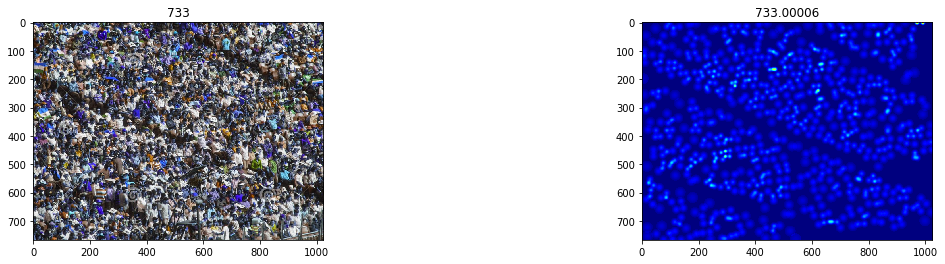

(90, 2)


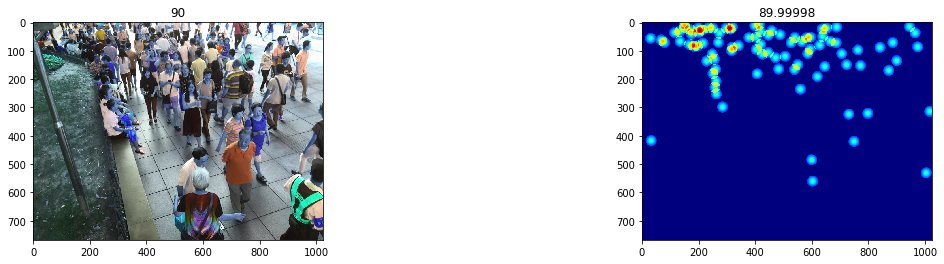

In [2]:
# Show a sample
img_paths = ['part_A/train_data/images/IMG_108.jpg',
             'part_B/train_data/images/IMG_20.jpg']
# from utils import load_img
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]
    print(gt.shape)

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(k, cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()

In [3]:
from data import CrowdDataSet 
import matplotlib.pyplot as plt
import numpy as np
from data import CrowdDataSet, CrowdClassificationDataSet
from data import default_train_transforms, default_test_transforms, default_train_transform_classification
from torchvision import transforms
from PIL import Image
from utils import get_density_map_gaussian

In [4]:
ds = CrowdDataSet('part_A/train_data/')

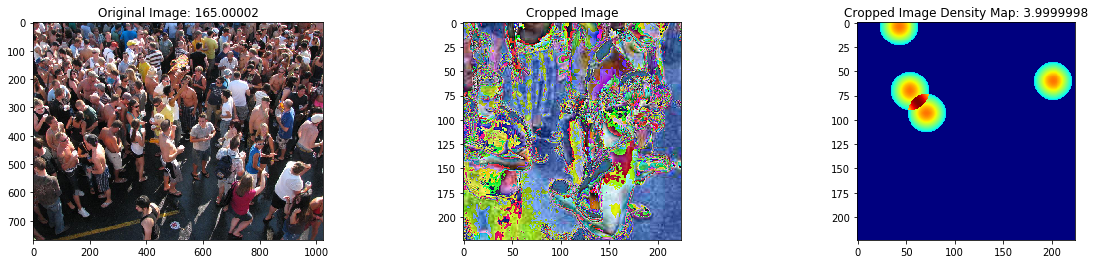

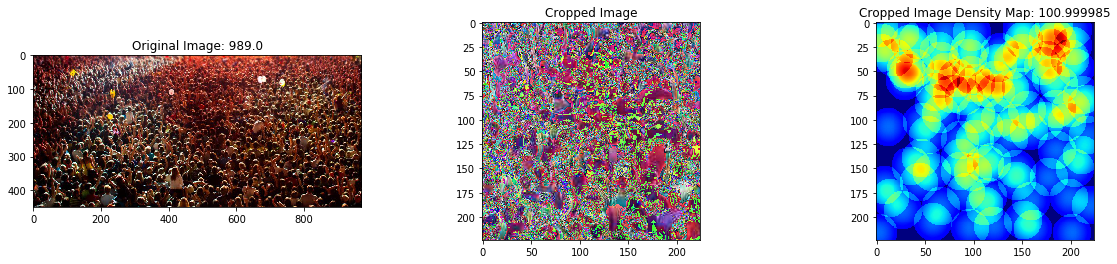

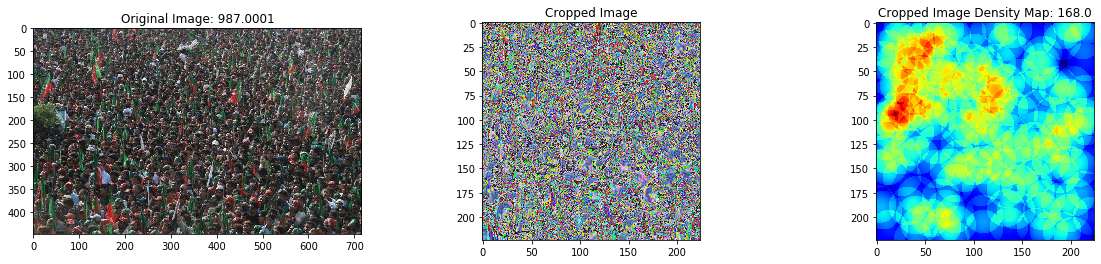

In [5]:
for i in [56, 57, 58]:
    fg, (p1, p2, p3) = plt.subplots(1, 3, figsize=(20, 4))

    x = ds[i]
    p1.imshow(x['image'])
    p1.set_title("Original Image: " + str(np.sum(x['den'])))

    loaders = {
        "train": CrowdDataSet(
            'part_A/train_data', default_train_transforms()
        ),
        "val": CrowdDataSet(
            'part_A/test_data', default_test_transforms()
        )
    }

    transformed_img = transforms.ToPILImage()(loaders['train'][i]['image']).convert('RGB')
    p2.imshow(transformed_img)
    p2.set_title("Cropped Image")

    k = np.zeros((transformed_img.width, transformed_img.height))
    k = get_density_map_gaussian(k, loaders['train'][i]['gt'], adaptive_mode=False)
    p3.imshow(k, cmap=plt.cm.jet)
    p3.set_title('Cropped Image Density Map: ' + str(np.sum(k)))

In [6]:
loaders = {
    "train": CrowdClassificationDataSet(
        'part_A/train_data', default_train_transform_classification()
    ),
    "val": CrowdClassificationDataSet(
        'part_A/test_data', default_train_transform_classification()
    )
}

In [7]:
import pandas as pd

pd.qcut([dt['num'] for dt in loaders['train']], 5, labels=False, retbins=True)

(array([4, 2, 1, 1, 2, 0, 4, 0, 1, 0, 2, 4, 3, 0, 2, 4, 3, 2, 0, 3, 1, 3,
        0, 2, 4, 1, 4, 0, 3, 0, 0, 2, 4, 0, 1, 4, 4, 0, 2, 1, 4, 3, 1, 3,
        2, 1, 0, 3, 2, 4, 4, 0, 0, 1, 0, 4, 0, 3, 4, 3, 3, 2, 2, 2, 0, 0,
        3, 0, 0, 0, 2, 0, 4, 3, 2, 1, 1, 1, 3, 4, 4, 2, 1, 1, 2, 2, 2, 3,
        0, 2, 3, 1, 1, 4, 4, 2, 4, 1, 0, 4, 4, 0, 3, 0, 1, 1, 0, 1, 3, 4,
        2, 3, 1, 0, 4, 1, 4, 0, 0, 2, 1, 2, 3, 0, 4, 1, 0, 1, 3, 3, 0, 3,
        4, 4, 1, 1, 4, 2, 2, 0, 2, 2, 0, 2, 4, 0, 3, 1, 0, 2, 3, 1, 0, 4,
        2, 0, 0, 4, 0, 3, 1, 1, 1, 4, 1, 2, 3, 1, 3, 3, 2, 4, 1, 3, 0, 4,
        4, 1, 3, 2, 2, 4, 3, 1, 1, 3, 4, 4, 2, 2, 3, 2, 0, 2, 1, 3, 3, 2,
        0, 2, 4, 0, 1, 2, 3, 4, 1, 1, 4, 3, 3, 3, 2, 0, 2, 0, 4, 4, 3, 0,
        4, 4, 3, 1, 0, 4, 0, 0, 4, 0, 1, 1, 1, 0, 0, 1, 3, 0, 2, 3, 1, 2,
        3, 3, 2, 4, 4, 4, 4, 2, 3, 1, 4, 3, 4, 3, 4, 2, 0, 4, 2, 0, 2, 2,
        2, 1, 1, 4, 2, 3, 2, 1, 2, 0, 4, 0, 1, 4, 2, 1, 3, 0, 2, 3, 3, 3,
        3, 1, 1, 1, 0, 3, 3, 3, 4, 3, 

In [8]:
nums = []
for data in loaders['train']:
    dt = data
    
    b = dt['bin']
    num = dt['num']
    nums.append(b)

In [9]:
print(sum([True if x == 0 else False for x in nums]))
print(sum([True if x == 1 else False for x in nums]))
print(sum([True if x == 2 else False for x in nums]))
print(sum([True if x == 3 else False for x in nums]))
print(sum([True if x == 4 else False for x in nums]))
print(len(nums))

60
59
60
60
60
300


In [1]:
import torchvision.models as models
import torch.nn as nn

In [5]:
conv_layers = list(models.resnet18(pretrained=True).children())[:8]
for layer in conv_layers:
    layer.requires_grad = False

model = nn.Sequential(
    *conv_layers,
    nn.Conv2d(512, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 1, kernel_size=3, padding=1),
    nn.ReLU(inplace=True)
)

model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [7]:
conv_layers = list(models.resnext50_32x4d(pretrained=True).children())[:8]
for layer in conv_layers:
    layer.requires_grad = False

model = nn.Sequential(
    *conv_layers,
    nn.Conv2d(512, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 1, kernel_size=3, padding=1),
    nn.ReLU(inplace=True)
)

model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,